# Bare Soil Peg - 11/06/2018


## From the last meeting

Bare soil in arid/semi-arid areas problems:
* Too high bare soil in tropical semi-arid ecosystem, leading to
* Incorrect IAV of carbon
* Too high dust emissions in UKESM etc
* Bare soil in Western Australia is particularly bad and overly sensitive to changes in moisture availability

Initial ideas:
* Vegetation in T/P climate space in  grass/BS transition areas for both observed and modelled
* Include difference between continent, inc. Australia and Sahel
* Impact of different types of variability - i.e seasonal, interannual, decadal?

## Some minutes from this one
- T/P plots below show to much bare soil onset at low precipitations.
- There may also be some issues in areas with highly seasonal rainfall or temperature.
- This is using the 5 PFT offline version, and we should swap to the configuration used as the basis for UKESM runs.
- For now, we shall pick the Sahel and explore/fix there before moving on to Australia etc. Sahel has nicer climate gradient, less influence of IAV than Aus, and could get some obs from AMA project etc.
- Some possible causes:
    - ET is too high, particularly in more arid regions (Andys plots)
    - Soil moisture could be too low (either cos of too high ET drying things out too quickly or another region)
    - Obviously NPP is too low so not enough is allocated to vegetation spread. Is respiration too high?
- Some things to check
    * What happens if we turn of soil evap?
    * How does our simulated soil moisture compare to observations (crossover with soil moisture JPEG)
    * It might be worth looking at the trend in simulated vegetation fractions in key regions

## Actions

#### Model analysis:
- **Andy**
    - Send round UKESM-based, 9 PFT JULES suite id and ET benchmarking
- **Doug**
    - Re-do analysis below with this suite
    - Check CCI comparison period


#### Model Experiments:
Soil moisture test for now:
- **Rich/Doug**
    - Try turning off soil E (could speak to Martin Best/Nic Gedney about their runs)
- **Karina/Doug**: 
    - Try using soil moisture suite for quick tests.
- **Karina**:
    - See if any of the CABLE changes could be used for quick tests.
    
   
Stuff to test if that doesn't work (though hold off till we see what above does):
- **Andy W**
    - Reducing/turning off respiration
- **unknown**
    - try prescribed veg run to check if plants actual do anything (i.e via productivity, LAI etc) & impact on soil moisture if veg frac is forced to be "correct".
    
 
#### Obs Collection:
- **Doug/Alistair**:
    - Look into CCI uncertain estimates/IGBP frac covers to get an idea of obs uncertainty
    - Look at the trend in veg fracs
- **Rich** 
    - Find any useful AMA site data on site based soil moisture/fluxes/veg properties in West Africa
    - Anything from CEH works on ET.

## Climate Space "Analysis"


### Setup
Start with importing some useful libraries

In [1]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')
sys.path.append('../libs_python')

# data munging and analytical libraries 
import re
import os
import numpy as np
import iris

# graphical libraries
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from   plot_maps       import *
from   ExtractLocation import *
from   listdir_path    import *
import jules
import convertpoints2grid

# setup nice plotting
plt.style.use('ggplot')#
%matplotlib inline

Obviouly the next box isn't normally a great idea, but when pushing to gothub for sharing, I'm going to supress some warnings. Best remove if actually adding some code.

In [2]:
import warnings
warnings.filterwarnings("ignore")

I only got a chance to grab 2000-2005 climate data before catching the train, so thats the time period we going to average over

In [3]:
start_year = 2000
end_year   = 2005

Where our jules output, cci and igbp "obs" and driving data are saved

In [4]:
jules_dir = '../../fireMIPbenchmarking/data/ModelOutputs/JULES-INFERNO-S2/'
rain_dir  = '../data/CRUNCEP/rain/'
tair_dir  = '../data/CRUNCEP/tair/'
igbp      = '../data/qrparm.veg.frac.nc'
cci       = '../data/cci_regridded.nc'

Luckily in our veg frac files (jules, igbp, cci) our pfts are in the same order, so here is the info about the names and tile number of our pfts we'll use for loading and plotting

In [5]:
pft_name    = ['BL', 'NL','C3G', 'C4G', 'SH', 'Bare Soil']
layer_no    = [0   , 1   , 2   , 3    , 4    , 7         ]

### Load Up some data

#### JULES veg frac

##### Open
Our JULES output and climate data can be opened in a simular way, using this function which finds the files for the right years, and makes and returns a climatology:

In [6]:
def open_files_annual_average(dir, s, e, FUN = jules, *arg, **kw):
    files = listdir_path(dir)
    years = np.array([int(file[s:e]) for file in files])
    files = np.array(files)
    files = files[(years >= start_year) & (years <= end_year)]
    dat = FUN.load(files, *arg, **kw)
    
    for i in dat[1:]: dat[0].data += i.data
    dat = dat[0] / len(dat)
    return(dat)

We'll just look annual average jules fractional cover for now, so we'll mean everything

In [7]:
frac_cover_jules = open_files_annual_average(jules_dir, -7, -3, jules, "Fractional cover of each surface type")
frac_cover_jules = frac_cover_jules.collapsed('time', iris.analysis.MEAN)[layer_no]

##### Plot
Let's just plot that up to see where out simulated pfts our.

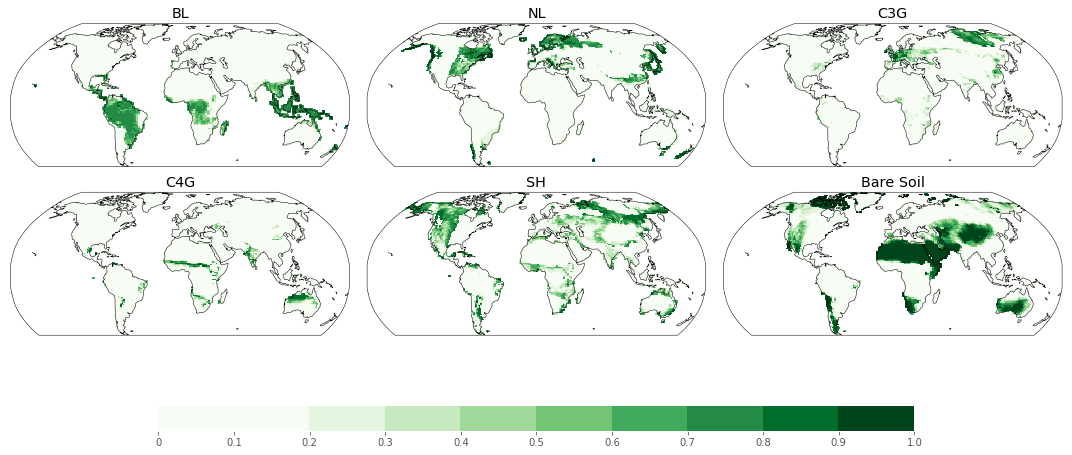

In [8]:
cover_levels  = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
cover_dlevels = [-0.5, -0.4, -0.3, -0.2, -0.1, -0.05, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

def plot_cover_data(cubes, cmap = 'brewer_Greens_09', levels = cover_levels, *args, **kw):
    plot_cubes_map(cubes, pft_name, cmap, levels, ny = 3, 
                   figXscale = 2.5, figYscale = 0.6, *args, **kw)

plot_cover_data(frac_cover_jules)

#### CCI frac cover
Our cci and IGBP data are both much easier to open, but are on a slightly different grid. So here is also a rather pragmatic way of getting obs veg frac and, eventually, climate data on the same grid as our jules output. Using iris regrid would be better.. but I can get it to work at the moment :S. Anyway, once open, we'll also plot it.

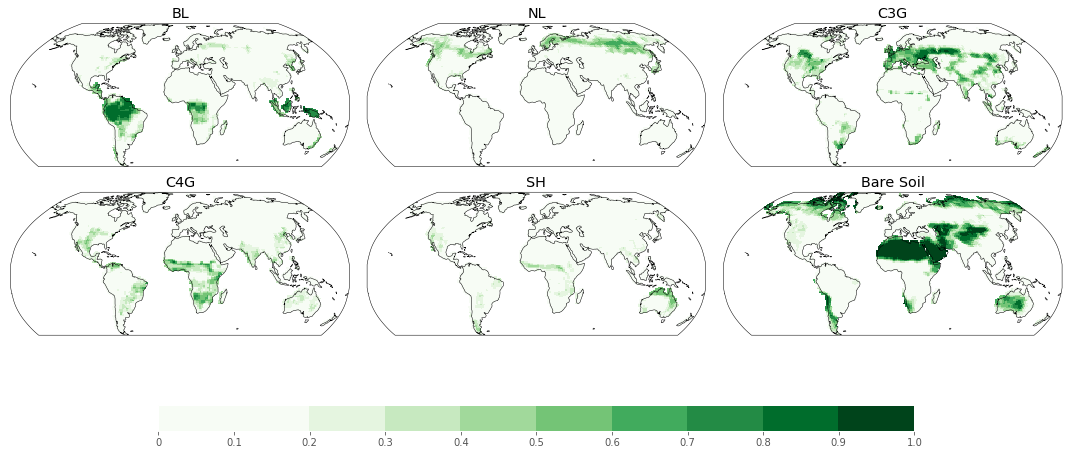

In [9]:
frac_cover_cci = iris.load_cube(cci)[layer_no]

def addLatLon(cube):
    cubei = frac_cover_jules[0].copy()
    cubei.data = cube.data[-117:-5:,]
    return(cubei)

def addLatLons(cube):
    index = range(0, cube.shape[0])
    cubei = frac_cover_jules[index].copy()
    for i in index: cubei.data[i] = cube.data[i][-117:-5:,]
    return(cubei)

frac_cover_cci = addLatLons(frac_cover_cci)
plot_cover_data(frac_cover_cci)

## IGPP, CCI error bars

#### Load IGBP

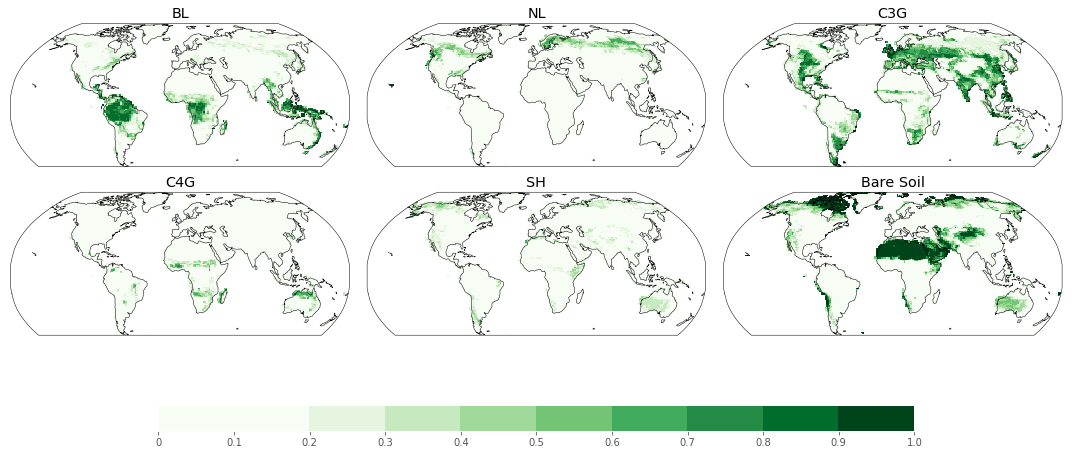

In [10]:
frac_cover_igbp = iris.load_cube(igbp)[layer_no]
frac_cover_igbp = addLatLons(frac_cover_igbp)

plot_cover_data(frac_cover_igbp)

#### Difference in datasets fractions
We'll use cci cos:
1. we're using it for the rest of the PEG
2. It has more bare soil than IGBP, so if we have too much bare soil in JULES, then we really have too much bare soil in JULES
2. It formed the basis on the analysis of our core runs where we first assessed this as a problem
3. Andy H has worked very hard on it
4. We can start using observational uncertainty at some point.

But here is the different between the two, mainly for interest for now

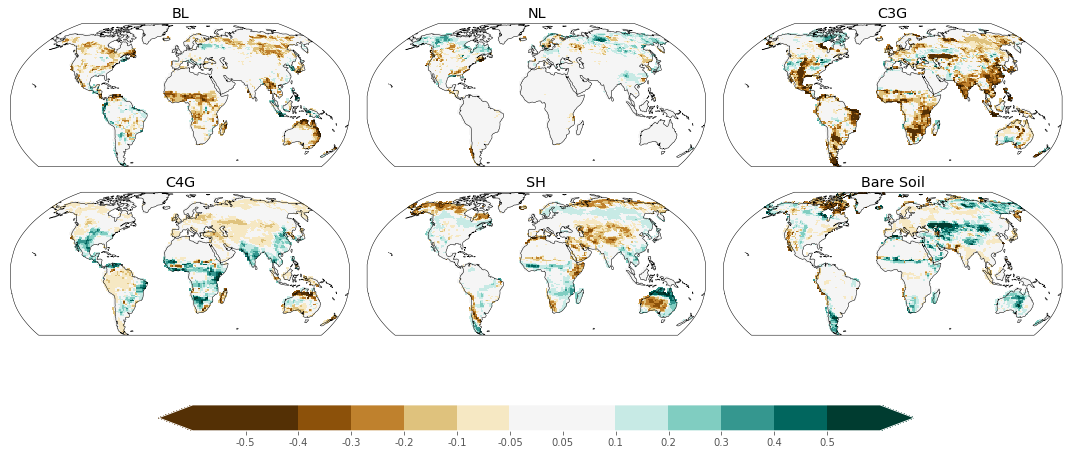

In [11]:
plot_cover_data(frac_cover_cci - frac_cover_igbp, "brewer_BrBG_11", cover_dlevels, extend = 'both')

Note anywhere were there is more cover in cci comes out blue, including bare soil cover. CCI genrally allocated more cover to bare soil than igbp, particularly at the expense of shrubs. There is also a a tendancy to allocate more grass cover to C4 over C3 in warmer climates. Some BL trees are assigned to srhubs in tropical/warm areas are allocated or NL in high latitudes.

#### JULES vs observations
As the title suggests, we're plotting the different between JULES and CCI Obs.

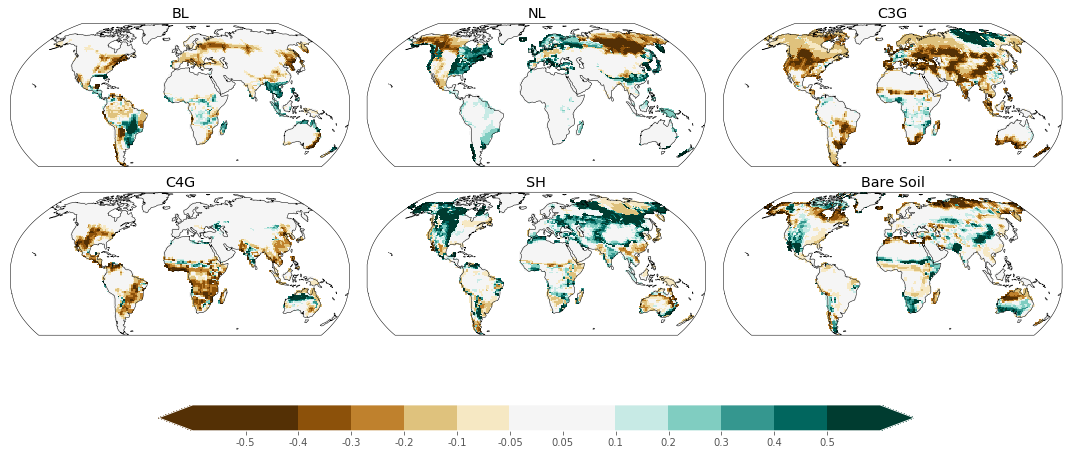

In [12]:
frac_cover_diff = frac_cover_jules.copy()
frac_cover_diff.data -= frac_cover_cci.data
frac_cover_diff
plot_cover_data(frac_cover_diff, "brewer_BrBG_11", cover_dlevels, extend = 'both')

 We have a few problem areas. Warm areas with too much bare soil include Central and Southern and semi-arid Southern Africa and America. Central Asia's stands out again as having too little vegetation. And there is a nice line of too much bare soil on the arid end of the Sahel which is tempting to explore. It's interesting that we also have places with too much vegetation. Maybe we'll do a veg soil JPEG at some point ;) 

I'll pick up on Central Asia (cos of temp gradient), Australia (precip gradient and IAV) and Sahel (nice precip gradient, plus a way of exploring seasonality) in a sec. But first we need climate data...

### Load climate

#### Rainfall
We'll load rain to start with. We going to look at mean annual precip and seasonality in precip. Inter annual variability might also be a good idea... just not from only 6 years of climate obs

In [13]:
rain = open_files_annual_average(rain_dir, -11, -7, iris, "Total_Precipitation")

#### Mean Annual Percip (MAP)
Easy peasy, just the time sum of rainfall, plus a bit of multiplication to get us to mm/yr

In [14]:
MAP = rain.collapsed('time', iris.analysis.SUM) * 60 * 60 * 4
MAP = addLatLon(MAP)

#### Seasonality
We'll follow Kelley et al. (2013) way of constructing rainfall seasonality metric. Partly cos I know how to construct it, and partly cos it's getting to be a well used way of representing climate seasonality. I wont go into the maths, but it basically says if all rainfall falls at the same timestep in our climatology, then our seasonal concentration is 1. If it's evenly spread through the year, then it has a concentration of 0. It is also therefore independant of total rainfall, so when we do a precip vs seasonality plot, our total precip isn't leaking onto our seasonality axis.

In [15]:
nt = rain.shape[0]
x = np.arange(0, 1, 1.0/nt) * 2 * np.pi
y = np.sin(x)
x = np.cos(x)

rain_x = rain.copy()
rain_y = rain.copy()

for i in range(0, nt): 
    rain_x.data[i] = rain.data[i] * x[i]
    rain_y.data[i] = rain.data[i] * y[i]
    

rain_x = rain_x.collapsed('time', iris.analysis.SUM)
rain_y = rain_y.collapsed('time', iris.analysis.SUM)

rain_v = np.power(rain_x, 2) + np.power(rain_y, 2)
rain_v = np.power(rain_v, (1/2))
rain_c = rain_v/rain.collapsed('time', iris.analysis.SUM)

rain_c = addLatLon(rain_c)


#### Rainfall mertics
Lets see what the both look like. Just to make sure we loaded then properly

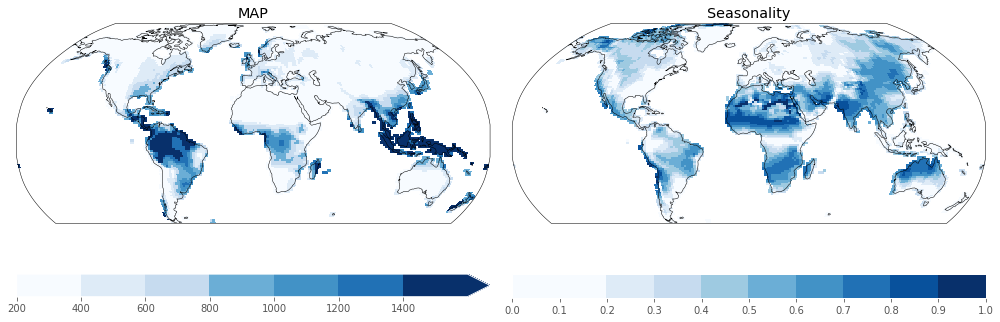

In [16]:
MAP.long_name = 'MAP'
rain_c.long_name = 'Seasonality'

plt.figure(figsize = (14, 5))
plot_lonely_cube(MAP   , 1, 2, 1, cmap = "brewer_Blues_09", levels = [200, 400, 600, 800, 1000, 1200, 1400], extend = 'max')
plot_lonely_cube(rain_c, 1, 2, 2, cmap = "brewer_Blues_09", levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

#### Air temp
Two very easy variables here which need no intricution:
1. Mean annual temperature (MAT)
2. Mean annual maximum temperarure (MxAT)

Note that MxAT is the maxmimum temp on our 4 hourly timestep... a lazy choice and maybe not the best annual maximum measure, but it'll do the job for now.

In [17]:
tair = open_files_annual_average(tair_dir, -11, -7, iris, "Temperature")

In [18]:
MAT = tair.collapsed('time', iris.analysis.MEAN) -273.15
MAT = addLatLon(MAT)

In [19]:
MxAT = tair.collapsed('time', iris.analysis.MAX) -273.15
MxAT = addLatLon(MxAT)

Lets see what the look like again

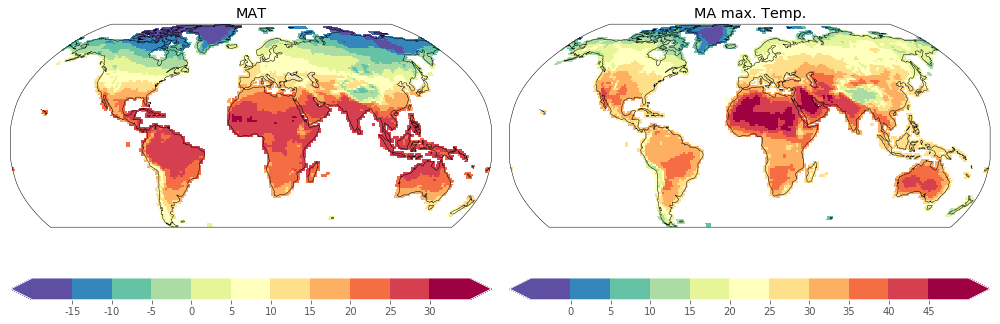

In [20]:
MAT.long_name = 'MAT'
MxAT.long_name = 'MA max. Temp.'

plt.figure(figsize = (14, 5))

plot_lonely_cube(MAT , 1, 2, 1, cmap = "Spectral_r", levels = [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30], extend = 'both')
plot_lonely_cube(MxAT, 1, 2, 2, cmap = "Spectral_r", levels = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45], extend = 'both')

### Veg frac climate zone
The reason you've made it this far! So, we have frac_cover from jules, frac_cover_cci from observations. And we'll see where in MAP, rain_c, MAT, MxAT they fall. First off, I'll define some messy plotting functions. Don't worry about these, the plots themselves should explain whats going on

In [21]:
def plot3BiomCLim (ax, x, y, z, title, xlim = None, ylim = None, cmap = 'RdYlGn_r', levels = cover_levels, alpha = 0.01):
    zs  = z.data.copy()
    zsi = zs.copy()

    zsi[:] = 0
    zsi[zs >= levels[-1]] = len(levels)
    
    for i, mn, mx in zip(range(len(levels) - 1), levels[:-1], levels[1:]):
        zsi[(zs > mn) & (zs < mx)] = i
    
    for i in [200, 150, 100, 75, 50, 25, 10, 5, 2, 1]:
        cf = ax.scatter(x.data, y.data, c = zsi, cmap = cmap, s = i, alpha = alpha)
    
    ax.set_title(title)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    #plt.colorbar(cf)
    #addColorbar(cf, levels, extend = 'both')
        
def extractArea(cubes, extent):
    return(ExtractLocation(cubes, extent[0], extent[1], extent[2], extent[3]).cubes)
   
def plotJulesCCI(x, y, title = '', pft = 5, extent = None, *args, **kw):
    
    if extent is not None:
        x = extractArea(x, extent)
        y = extractArea(y, extent)          
        z1 = extractArea(frac_cover_cci[pft], extent)
        z2 = extractArea(frac_cover_jules[pft], extent)
        
        #z3 = extractArea(frac_cover_diff[pft], extent)
    else:
        z1 = frac_cover_cci[pft]
        z2 = frac_cover_jules[pft]
        #z3 = frac_cover_diff[pft]
    
    plt.rcParams['figure.figsize'] = (16, 5)
    fig, ax = plt.subplots(1,3, sharey=True)    
    plot3BiomCLim(ax[0], x, y, z1, 'CCI', *args, **kw)    
    plot3BiomCLim(ax[1], x, y, z2, 'JULES', *args, **kw)
    plot3BiomCLim(ax[2], x, y, z2 - z1, 'JULES - CCI', levels = cover_dlevels, *args, **kw)
    
    plt.gcf().suptitle(title, fontsize=14)



#### Global
Lets look at out gobal T/P plot to start with. 

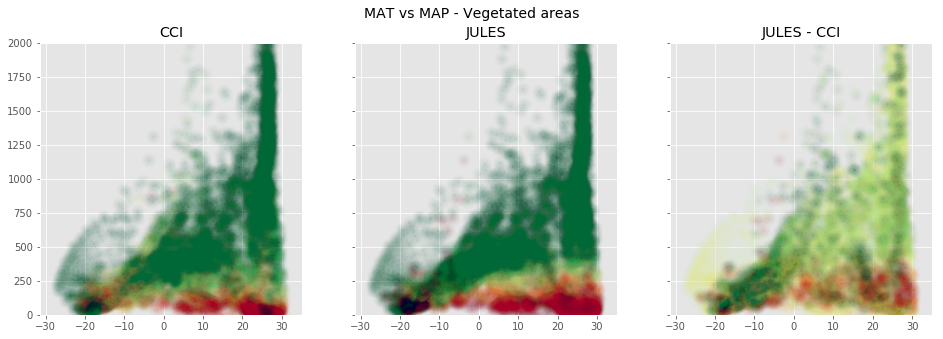

In [22]:
plotJulesCCI(MAT, MAP, 'MAT vs MAP - Vegetated areas', ylim = [0, 2000])

I need to add a legend at some point... but bascially above, green = vegetated; brown = bare soil. We get bare soil in JULES at low precip, just like cci. Thats something at least. But even in the global plot, we can see our bare soil extends to far up the precip gradient, wit max. bare soil reached at rougly 250mm/year at an MAT of 15+, and a vegetation cover deficit right upto 400 mm/yr.

Lets zoom in on a couple of places to see whats going on in some more details.

#### Australia - were veg models always do a bad job

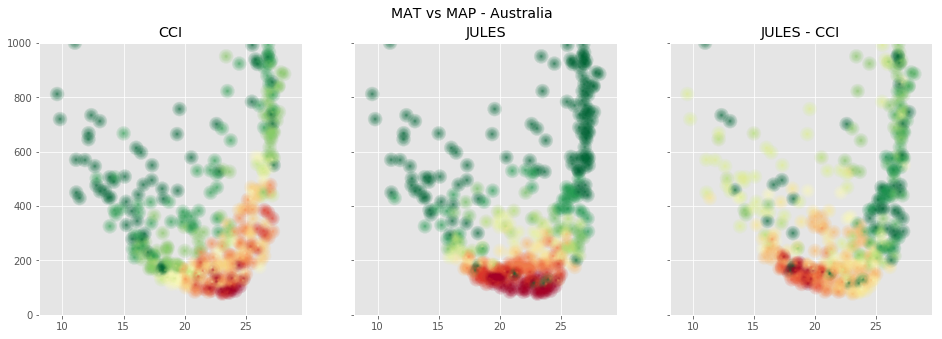

In [23]:
extent = [110, 160, -50, -10]
plotJulesCCI(MAT, MAP,'MAT vs MAP - Australia', extent = extent, ylim = [0, 1000], alpha = 0.1)

So yep, too much bare soil in Australia. And again at the drier end, Bt also, our change in vegetated fraction of temp graident is too flat compared to CCI. So at intermediate rainfall (200-400mm/yr) and high temp (MAT ~ 23 deg C +), we actually get to much veg, whereas our big, low rainfall bare soil problem is at lower MATs (15-20). But remeber Northern Aus is the warm but, and that has other climate stuff going on, so it might not be temp...

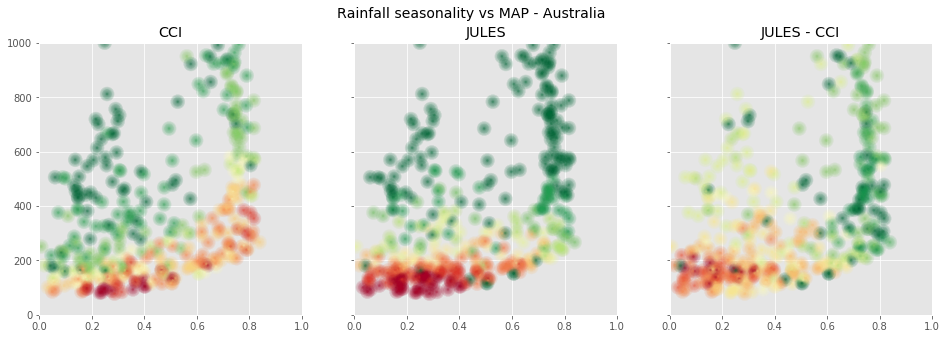

In [24]:
plotJulesCCI(rain_c, MAP,'Rainfall seasonality vs MAP - Australia', extent = extent, ylim = [0, 1000], xlim = [0, 1], alpha = 0.1)

Here, I've replaced MAT with seasonality. Remember 1 = highly seasonal rainfall. Looks like in cci, veg frac also goes down at intermediate climates with high seasonality, whereas in JULES it's the oppesite. Also, even at high rainfall and high seasonality, where there is some cover in obs, we still simulate to much vegetation. Seasonally wet climates are prime fire zones, something not included in this JULES run. Here's a breakdown by shrub and grass pft. All have their own special miss-matches:

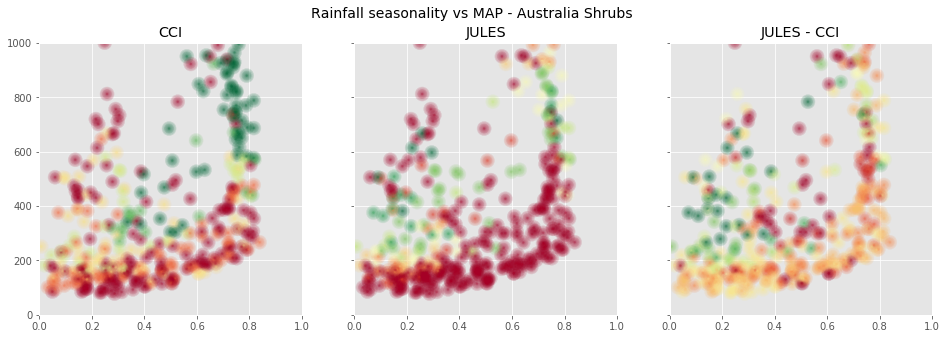

In [25]:
plotJulesCCI(rain_c, MAP,'Rainfall seasonality vs MAP - Australia Shrubs', cmap = 'RdYlGn', extent = extent, pft = 4, ylim = [0, 1000], xlim = [0, 1], alpha = 0.1)

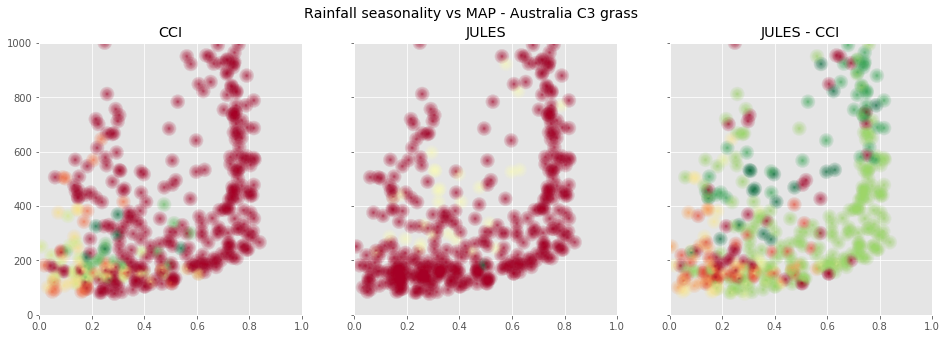

In [26]:
plotJulesCCI(rain_c, MAP,'Rainfall seasonality vs MAP - Australia C3 grass', cmap = 'RdYlGn', extent = extent, pft = 2, ylim = [0, 1000], xlim = [0, 1], alpha = 0.1)

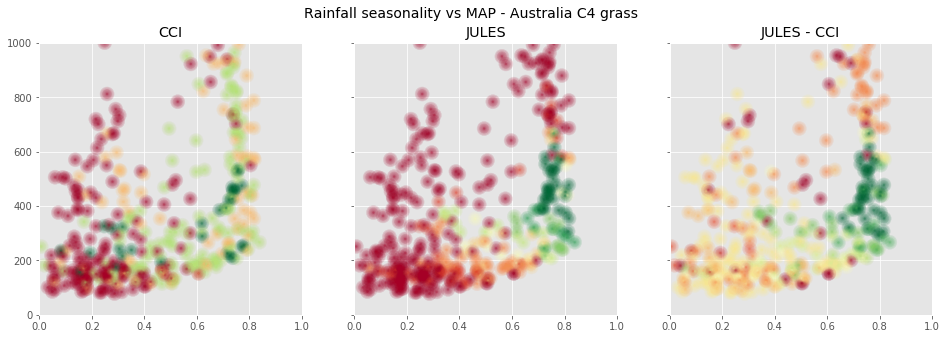

In [27]:
plotJulesCCI(rain_c, MAP,'Rainfall seasonality vs MAP - Australia C4 grass', cmap = 'RdYlGn', extent = extent, pft = 3, ylim = [0, 1000], xlim = [0, 1], alpha = 0.1)

### Central Asia

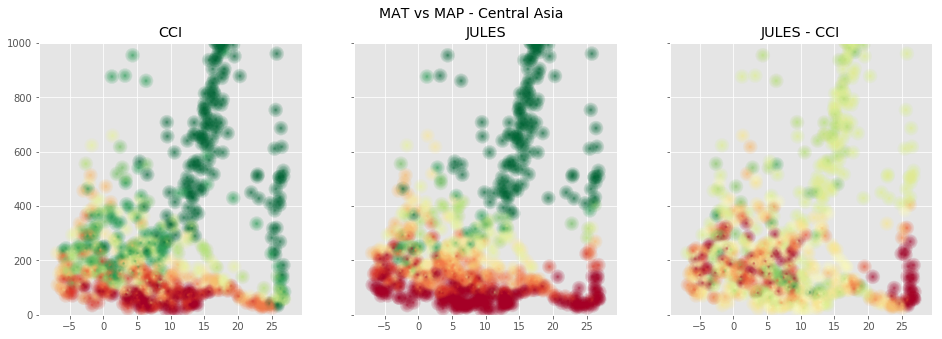

In [28]:
extent = [60, 120, 25, 50]
plotJulesCCI(MAT, MAP,'MAT vs MAP - Central Asia', extent = extent, ylim = [0, 1000], alpha = 0.1)

With our bigger temp range in Central Asia... we see a simular relationship to global. To much bare soilm kicking in around 400 mm/yr, with almost 100% from 250 mm/yr. All around x2 the cci obs

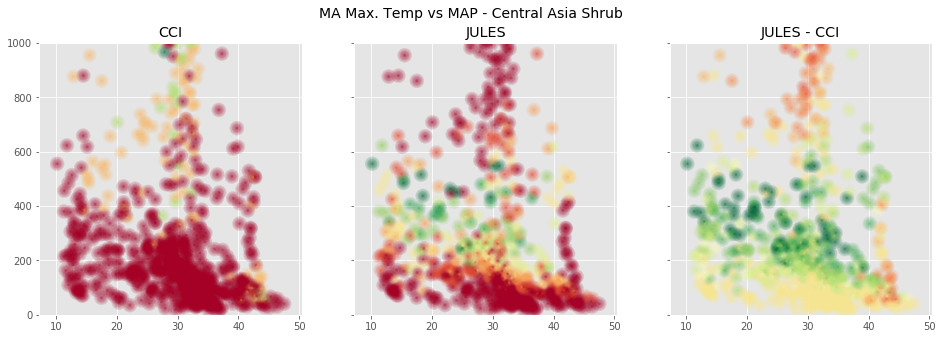

In [29]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia Shrub', cmap = 'RdYlGn', pft = 4, extent = extent, ylim = [0, 1000], alpha = 0.1)

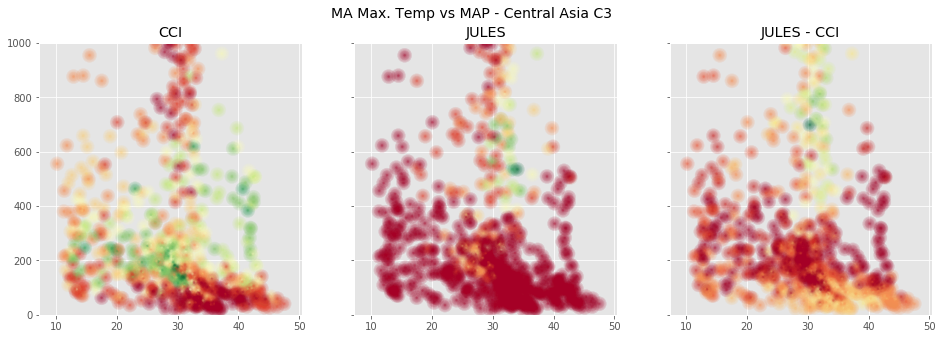

In [30]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia C3', cmap = 'RdYlGn', pft = 2,extent = extent, ylim = [0, 1000], alpha = 0.1)

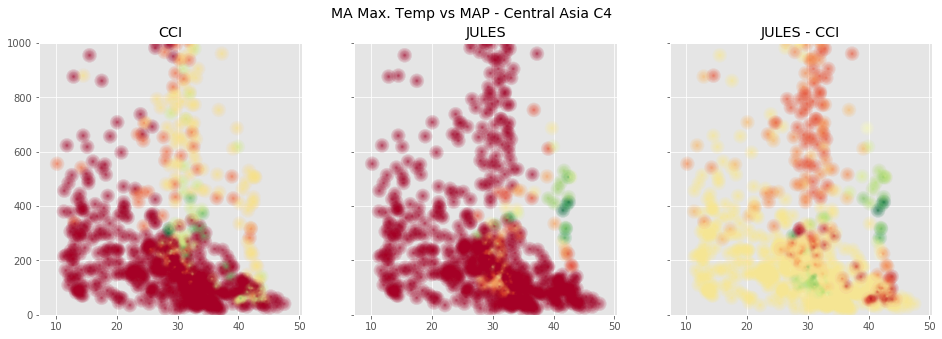

In [31]:
plotJulesCCI(MxAT, MAP,'MA Max. Temp vs MAP - Central Asia C4', cmap = 'RdYlGn', pft = 3, extent = extent, ylim = [0, 1000], alpha = 0.1)

#### Sahel
I'm going to look at the Sahel in a bit more detail, cos of that nice, smooth moisture gradient

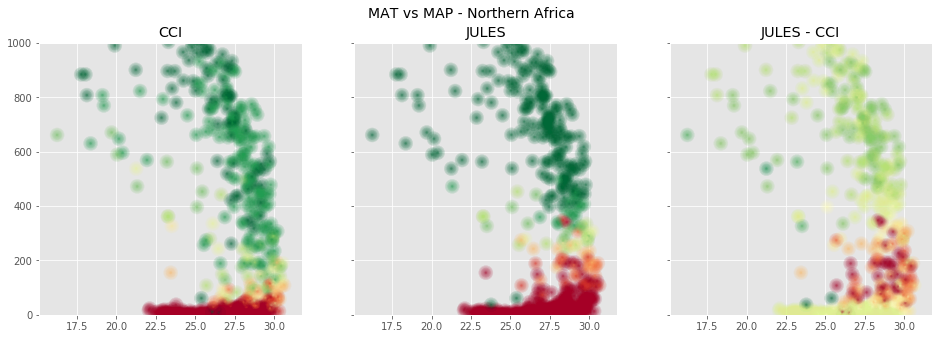

In [32]:
extent = [-20, 40, 0, 25]
plotJulesCCI(MAT, MAP,'MAT vs MAP - Northern Africa', extent = extent, ylim = [0, 1000], alpha = 0.1)


Out bare soil moisture problem stands out a lot more here than anywhere else, which a vegetative deficit from ~50mm/yr right up 400 mm/yr. 

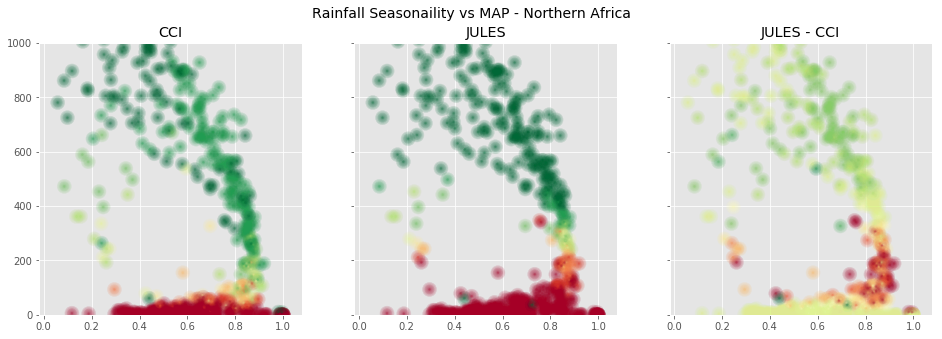

In [33]:
plotJulesCCI(rain_c, MAP,'Rainfall Seasonaility vs MAP - Northern Africa', extent = extent, ylim = [0, 1000], alpha = 0.1)

Northern Africa is generally quiet a warm place along that moisture graident. Unfortunatly, swapping in Seasonality doesn't change the general look at the plot, with quiet high seasonality at our vegetative definict bit of the plot as well.

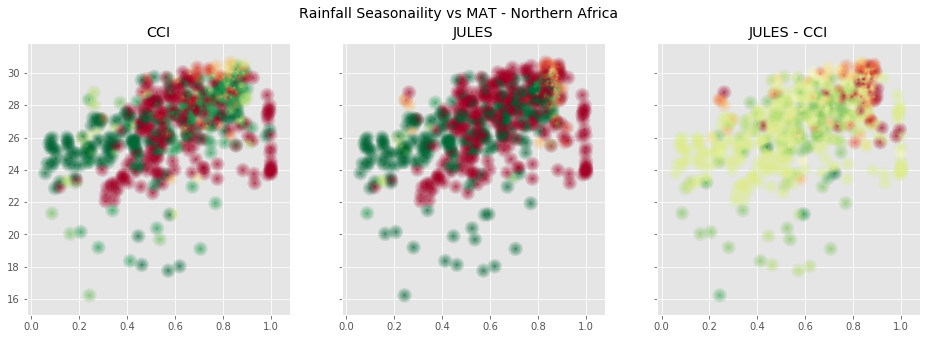

In [34]:
plotJulesCCI(rain_c, MAT,'Rainfall Seasonaility vs MAT - Northern Africa', extent = extent, alpha = 0.1)

Looking at MAT vs rainfall seasonality, it looks like our vare soil problem is in highly seasonal, dry locations. So maybe its both...? Although we're no longer factoring in rainfall...

Anyway, keeping things simple, lets look at our standard T/P plot.

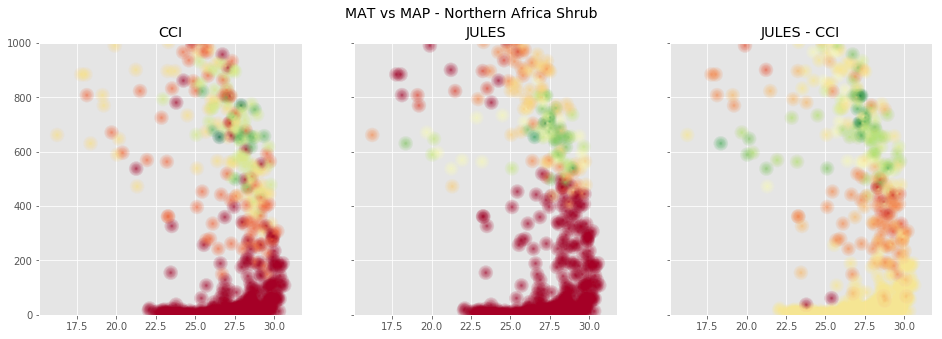

In [40]:
plotJulesCCI(MAT, MAP,'MAT vs MAP - Northern Africa Shrub', cmap = 'RdYlGn', pft = 4,
             extent = extent, ylim = [0, 1000], alpha = 0.1)

Our lack of shrubs might account for some of our deficit at some of the higher precip ranges (~400 mm/yr). It looks like lack of shrubs extends to higher rainfall as well, but thats getting into the relms of competition problems, so we'll ignore that for this bit of the PEG

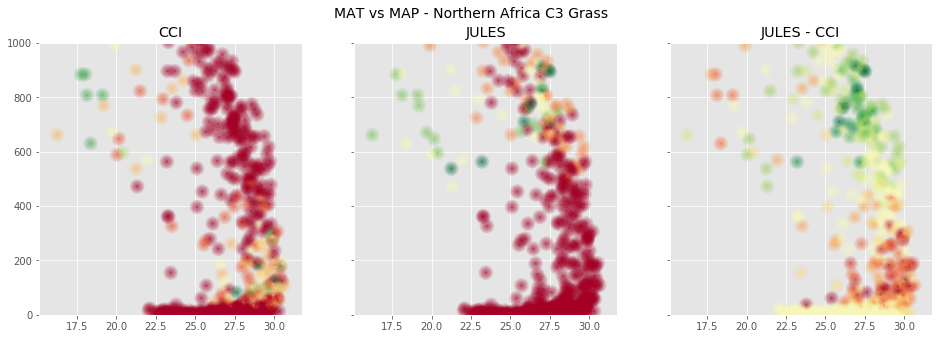

In [41]:
plotJulesCCI(MAT, MAP,'MAT vs MAP - Northern Africa C3 Grass', cmap = 'RdYlGn', pft = 2, 
             extent = extent, ylim = [0, 1000], alpha = 0.1)

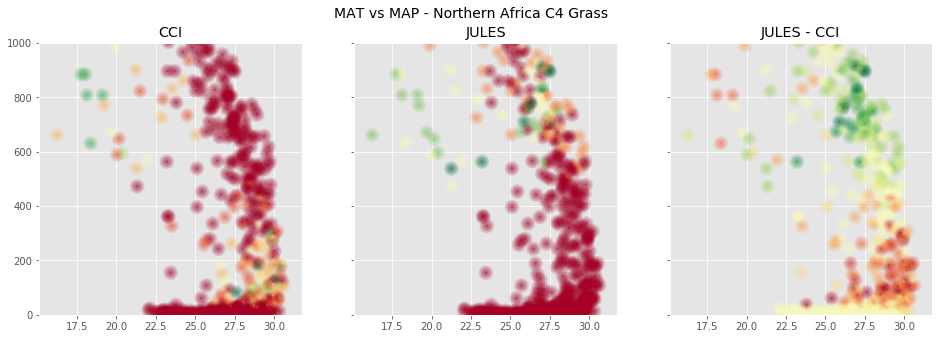

In [42]:
plotJulesCCI(MAT, MAP,'MAT vs MAP - Northern Africa C4 Grass', cmap = 'RdYlGn', pft = 2, 
             extent = extent, ylim = [0, 1000], alpha = 0.1)

And finally a grass deficit makes up most of the lower end of our vegetation deficit (< 300 mm/yr)